<a href="https://colab.research.google.com/github/DOMEscho/saki-recommender-system/blob/main/SAKI_reco_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender system exercises

You'll need to install the packages pandas and matplotlib for this exercise.

We're working with the movielens data set, the smaller version. This data set contains 100k ratings for 9000 movies from 600 users.

We'll have a look at the data, implement collaborative filtering, and look at some typical metrics.

## Getting the data

Uncomment the lines in the next box and this will download the files and unzip them in this directory.


In [6]:
# Do this only once!
#wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
#unzip ml-latest-small.zip

--2021-06-20 19:09:58--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  5.73MB/s    in 0.2s    

2021-06-20 19:09:58 (5.73 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


These are the includes for the rest of the notebook

In [7]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

## Reading the movie data

Let's start by reading the movie data and define a function findMovieByTitle that returns all movies which match a given string.

We'll use the [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) library for loading. Key to performance is to not manually iterate over the data, but use built-in functions as much as possible.

In [8]:
movies = pd.read_csv('ml-latest-small/movies.csv', index_col='movieId') # why is it called index_col, not index

In [9]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


Implement a function findMovieByTitle that returns all movies whose title matches the string passed.

Then, let's return all movies containing the term 'Matrix'

In [10]:
# a function to do some exploration
def find_movie_by_title(title):
    return movies[movies.title.str.find(title) != -1]

find_movie_by_title('Matrix')

,title,genres
movieId,,
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
6365,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
6934,"Matrix Revolutions, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX


## Reading the ratings data

Next, we'll load the ratings data set. Use datetime.datetime.fromtimestamp to convert the timestamp column to an actual datetime object (this will make it more readable)

In [11]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.timestamp = ratings.timestamp.apply(datetime.datetime.fromtimestamp) # datetime.datetime WTF

userIds = ratings.userId.unique()


In [12]:
ratings.shape

(100836, 4)

Now, define a function ratingsForUser that takes a user id and returns all the entries from the ratings table for that user.

In [13]:
# again, another function to find some data
def ratings_for_user(uid):
  return ratings[ratings.userId == uid]

ratings_for_user(20)

,userId,movieId,rating,timestamp
2977,20,2,3.0,2003-05-27 12:25:13
2978,20,8,1.0,2003-05-27 12:27:02
2979,20,13,4.0,2003-05-27 12:27:05
2980,20,34,4.0,2003-05-27 12:21:33
2981,20,48,5.0,2003-05-27 12:25:57
...,...,...,...,...
3214,20,6297,4.0,2003-05-27 11:57:50
3215,20,6333,4.0,2003-05-27 11:56:56
3216,20,6345,5.0,2003-05-27 11:57:03
3217,20,6358,3.5,2003-05-28 18:45:05


Let's do some data exploration. Compute the number of ratings per user and plot the histogram. Hint, use the [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function from pandas. 

In [21]:
# compute a histogram of number of ratings.
def number_of_ratings_per_user():
  return ratings.groupby(by=['userId'], 
                         axis=0,
                         as_index=True, 
                         sort=True,
                         dropna=True).agg(
                             number_of_ratings=pd.NamedAgg(column='movieId', aggfunc='count')
                         )

nr_of_ratings = number_of_ratings_per_user()
nr_of_ratings

,number_of_ratings
userId,
1,232
2,29
3,39
4,216
5,44
...,...
606,1115
607,187
608,831


In [15]:
ratings[ratings['rating'].isna()]

,userId,movieId,rating,timestamp


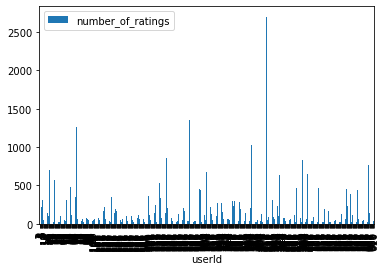

In [16]:
nr_of_ratings.plot.bar()


This data set looks highly skewed as often the case. Most users have only a small number of ratings. What is the minimum number of ratings in the data set?

In [17]:
nr_of_ratings.min()

number_of_ratings    20
dtype: int64

In [44]:
nr_of_ratings[nr_of_ratings.number_of_ratings == nr_of_ratings.number_of_ratings.min()]

,number_of_ratings
userId,
53,20
147,20
189,20
194,20
207,20
257,20
278,20
320,20
406,20


What is the movie with the most views?

In [19]:
def number_of_ratings_per_movie():
   return ratings.groupby(by=['movieId'], 
                         axis=0,
                         as_index=True, 
                         sort=True,
                         dropna=True).agg(
                             number_of_ratings=pd.NamedAgg(column='movieId', aggfunc='count')
                         )

number_of_ratings_per_movie_ = number_of_ratings_per_movie()
number_of_ratings_per_movie_
number_of_ratings_per_movie_[number_of_ratings_per_movie_.number_of_ratings == number_of_ratings_per_movie_.number_of_ratings.max()]

,number_of_ratings
movieId,
356,329


In [125]:
movies.loc[356]

title          Forrest Gump (1994)
genres    Comedy|Drama|Romance|War
Name: 356, dtype: object

This is a all not very informative. Try joining the movies data to this result set so that you can see the title and the other columns as well. (Hint: you need to use the 'on=' keyword int he join function)

In [22]:
movies_extended = movies.join(number_of_ratings_per_movie_, on='movieId')
movies_extended.join(ratings, on='movieId')
movies_extended

,title,genres,number_of_ratings
movieId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215.0
2,Jumanji (1995),Adventure|Children|Fantasy,110.0
3,Grumpier Old Men (1995),Comedy|Romance,52.0
4,Waiting to Exhale (1995),Comedy|Drama|Romance,7.0
5,Father of the Bride Part II (1995),Comedy,49.0
...,...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,1.0
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,1.0
193585,Flint (2017),Drama,1.0


Likewise, what's the best rated movie of all times?

In [23]:
ratings_extended_on_movieId = ratings[['movieId', 'rating']].groupby(by=['movieId']).agg({'rating': ['mean', 'max', 'min']})

In [24]:
movies_extended2 = movies_extended.join(ratings_extended_on_movieId, on='movieId')

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


In [127]:
five_stars = movies_extended2[movies_extended2[('rating', 'mean')] == movies_extended2[('rating', 'mean')].max()]
five_stars

,title,genres,number_of_ratings,"(rating, mean)","(rating, max)","(rating, min)"
movieId,,,,,,
53,Lamerica (1994),Adventure|Drama,2.0,5.0,5.0,5.0
99,Heidi Fleiss: Hollywood Madam (1995),Documentary,2.0,5.0,5.0,5.0
148,"Awfully Big Adventure, An (1995)",Drama,1.0,5.0,5.0,5.0
467,Live Nude Girls (1995),Comedy,1.0,5.0,5.0,5.0
495,In the Realm of the Senses (Ai no corrida) (1976),Drama,1.0,5.0,5.0,5.0
...,...,...,...,...,...,...
176601,Black Mirror,(no genres listed),1.0,5.0,5.0,5.0
179133,Loving Vincent (2017),Animation|Crime|Drama,1.0,5.0,5.0,5.0
179135,Blue Planet II (2017),Documentary,1.0,5.0,5.0,5.0


In [132]:
five_stars[five_stars['title'].str.contains('Belle')]

,title,genres,number_of_ratings,"(rating, mean)","(rating, max)","(rating, min)"
movieId,,,,,,
6442,Belle époque (1992),Comedy|Romance,2.0,5.0,5.0,5.0


The top seems to be movies with very few ratings, only look at movies that have twenty or more ratings.

In [134]:
movies_xattr_suff = movies_extended2[movies_extended2.number_of_ratings >= 20]
movies_xattr_suff[movies_xattr_suff[('rating', 'mean')] == movies_xattr_suff[('rating', 'mean')].max()]

,title,genres,number_of_ratings,"(rating, mean)","(rating, max)","(rating, min)"
movieId,,,,,,
1104,"Streetcar Named Desire, A (1951)",Drama,20.0,4.475,5.0,3.0


# Toy data

Before we go into working on collaborative filtering, let's define a toy data set. This is generally good practice if you are working with real-world data sets. Toy data is smaller and you can work faster, but you can also design it in a way that you know the outcome.

In [27]:
toyratings = pd.DataFrame(data={
    'userId': [1, 1, 1, 1, 1,
              2, 2, 2,
              3, 3, 3],
    'movieId': [1,2,3,4,8,
               1,2,3,
               2,3,5],
    'rating': [5.0, 4.0, 3.0, 2.0, 1.0,
               1.0, 2.0, 3.0,
               3.0, 3.0, 3.0],
    'timestamp': ['2021-01-01 10:00', '2021-01-02 08:00', '2021-01-03 09:00', '2021-01-04 10:00', '2021-01-05 11:00',
                 '2021-01-10 08:00', '2021-01-11 09:00', '2021-01-13 10:00',
                '2021-01-07 08:00', '2021-01-09 09:00', '2021-01-11 10:00']
                  
})
toyratings

,userId,movieId,rating,timestamp
0,1,1,5.0,2021-01-01 10:00
1,1,2,4.0,2021-01-02 08:00
2,1,3,3.0,2021-01-03 09:00
3,1,4,2.0,2021-01-04 10:00
4,1,8,1.0,2021-01-05 11:00
5,2,1,1.0,2021-01-10 08:00
6,2,2,2.0,2021-01-11 09:00
7,2,3,3.0,2021-01-13 10:00
8,3,2,3.0,2021-01-07 08:00
9,3,3,3.0,2021-01-09 09:00


# Collaborative filtering

We will now (finally) implement collaborative filtering. For two movies, it looks at the ratings of all users and computes the cosine similarities between these vectors. It might sound simple, but works if you have sufficient amounts of data, and is often a good first version.

We're not dealing with this here, but for future reference: It is not personalized, and you don't know how to do recommendations for new items. There are other methods that look at customer events, or take content into account to deal with these kinds of problems. Factorization methods can also help if your data is very sparse.

Implement a function that takes the ratings dataframe and returns a dataframe which contains movie to movie similarities. You can convert the dataframe to a numpy array to work with matrix algebra. Try to avoid using explicit for loops.

In [28]:
large_width = 500
np.set_printoptions(linewidth=large_width)

In [29]:
def collaborative_filtering(ratings):
    # TODO: Make sure the are always sorted by userId, then by moviId
    tmp = pd.DataFrame(ratings[['movieId', 'userId', 'rating']]).set_index(['userId'])
    tmp = tmp.pivot_table(values='rating',
                          index=tmp.index,
                          columns='movieId',
                          aggfunc='first')
    userIds = tmp.index.values
    movieIds = tmp.columns.values
    # tmp has still nan entries.
    # For now we just fill them with zero
    user_item = tmp.to_numpy(na_value=0)
    # Add a centered approach would properably beneficial
    item_sim = user_item.T @ user_item
    norms = np.array([np.sqrt(np.diagonal(item_sim))])
    N = norms.T @ norms
    sim = item_sim / N
    sim_df = pd.DataFrame(sim, index=movieIds, columns=movieIds)
    sim_df.index.name = 'movieId'    
    return sim_df

collaborative_filtering(toyratings)

,1,2,3,4,5,8
movieId,,,,,,
1,1.000000,0.801193,0.679366,0.980581,0.000000,0.980581
2,0.801193,1.000000,0.964901,0.742781,0.557086,0.742781
3,0.679366,0.964901,1.000000,0.577350,0.577350,0.577350
4,0.980581,0.742781,0.577350,1.000000,0.000000,1.000000
5,0.000000,0.557086,0.577350,0.000000,1.000000,0.000000
8,0.980581,0.742781,0.577350,1.000000,0.000000,1.000000


Let's store the result in the _sims_ variable for the full rating data set and in the _ts_ variable for the toyratings.

In [30]:
sims = collaborative_filtering(ratings)
sims

ts = collaborative_filtering(toyratings)
ts

,1,2,3,4,5,8
movieId,,,,,,
1,1.000000,0.801193,0.679366,0.980581,0.000000,0.980581
2,0.801193,1.000000,0.964901,0.742781,0.557086,0.742781
3,0.679366,0.964901,1.000000,0.577350,0.577350,0.577350
4,0.980581,0.742781,0.577350,1.000000,0.000000,1.000000
5,0.000000,0.557086,0.577350,0.000000,1.000000,0.000000
8,0.980581,0.742781,0.577350,1.000000,0.000000,1.000000


For getting recommendations quickly, let create another dataframe where each row is the ids of the recommendations. We get this by sorting the rows of the similarity dataframe.

Write a function _allrecos_ that takes the similarity matrix computed by _collaborative_filtering_ and returns another dataframe with the values such that the first column is the movie itself (highest similarity), the second column is the second most similar, and so on...

In [31]:
def allrecos(sims):
    # dataframe: movie_id with highest sim, movie_id
    movie_ids = sims.columns.values
    recos = sims.copy()
    
    def sorting_by_sim(row):
      idx_movie_ids = movie_ids
      sim_ids = list(zip(row, idx_movie_ids))
      return [item[1] for item in sorted(sim_ids, reverse=True)]

    # Since we don't want to list the movie itself as a recommendation for this movie
    # we set the similarity to -1
    np.fill_diagonal(recos.values, -1)
    
    # Order the rows by similarity
    recos = recos.apply(lambda row: sorting_by_sim(row), axis=1, result_type='expand')
    
    # Add column labels
    recos.columns = [f'{pos}.' for pos in range(1, sims.shape[0]+1)]
    # Drop the last column which contains the same movieId as the index
    return recos.iloc[:, :-1]

recos = allrecos(sims)
#recos = allrecos(ts)
#recos

Finally, we define the function getReco that takes the recommendation dataframe, a movie id, and optinally a number of items to recommend and returns a 

In [32]:
def getReco(recos, movie_id, n=10):
  return recos.loc[movie_id, recos.columns[:n]]

getReco(recos, 1)

1.     3114
2.      480
3.      780
4.      260
5.      356
6.      364
7.     1210
8.      648
9.     1265
10.    1270
Name: 1, dtype: int64

As we did above, if we join with the movies table we can also see what we're recommending.

Write a function `printReco` that takes the recommendation table, a movie id, optionally a number of recommendations to return and joins the information from the movies table to the recommendations. Make it also output the title of the passed movie id.

Hint: you can use to_frame(name='movieId') to turn the recommendations into a dataframe that can be joined more easily with the movies dataframe.

In [33]:
def printReco(recos, movie_id, n=10):
    tmp = getReco(recos, movie_id, n).to_frame(name='movieId')
    title = movies.loc[movie_id, 'title']  
    printable_reco = tmp.join(movies, on='movieId')
    printable_reco.index.name = 'Rank'
    
    print(f'The top-{n} recommendations for {title}:')
    display(printable_reco)

printReco(recos, 1)

The top-10 recommendations for Toy Story (1995):


,movieId,title,genres
Rank,,,
1.,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
2.,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
3.,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
4.,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
5.,356,Forrest Gump (1994),Comedy|Drama|Romance|War
6.,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
7.,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
8.,648,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
9.,1265,Groundhog Day (1993),Comedy|Fantasy|Romance


What are the recommendations for the first Matrix movie?

In [34]:
find_movie_by_title('Matrix')
movieId = 2571
printReco(recos, movieId)

The top-10 recommendations for Matrix, The (1999):


,movieId,title,genres
Rank,,,
1.,2959,Fight Club (1999),Action|Crime|Drama|Thriller
2.,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
3.,2028,Saving Private Ryan (1998),Action|Drama|War
4.,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
5.,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
6.,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
7.,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery
8.,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
9.,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure


What are the recommendations to 'When Harry Met Sally'?

In [35]:
find_movie_by_title('When Harry Met Sally')
movieId = 1307
printReco(recos, movieId)

The top-10 recommendations for When Harry Met Sally... (1989):


,movieId,title,genres
Rank,,,
1.,2797,Big (1988),Comedy|Drama|Fantasy|Romance
2.,1265,Groundhog Day (1993),Comedy|Fantasy|Romance
3.,1968,"Breakfast Club, The (1985)",Comedy|Drama
4.,2396,Shakespeare in Love (1998),Comedy|Drama|Romance
5.,1393,Jerry Maguire (1996),Drama|Romance
6.,1259,Stand by Me (1986),Adventure|Drama
7.,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi
8.,2716,Ghostbusters (a.k.a. Ghost Busters) (1984),Action|Comedy|Sci-Fi
9.,2100,Splash (1984),Comedy|Fantasy|Romance


# Now let's compute some metrics

As you hopefully saw from the above examples, the algorithm seems to be making more or less sense. However, in practice, you'll want to define some metrics that can objectively measure how well the algorithm works. We're looking at two measures here, views@n and mean reciprocal rank@n.

The "@n" part measures how many recommendations you want.

views@n measure the percentage of recommendations that contained the next movie viewed by a users.

mrr@n measures the mean reciprocal rank: you take the position p of the item that has been viewed and take the 1/p and then take the mean over all recommendations.

This setting simulates a setting where we would have shown our recommendations after each view and measures whether we were able to recommend something that people viewed.

The analysis is very simple and also incorrect strictly speaking because our model has been trained on the views we are using to evaluate. Since the model is very simple, we'll probably not see overfitting.

## Looking at the next recommendation

As a first step, we need to collect pairs of movieId and next movieId from the ratings. The ratings table is already sorted by userIds, but the times are bit all over the place. Sort the ratings table first by userId and timestamp.

I personally didn't find a good way to do this with pandas operations, so iterate over the whole table. Or try to find a better solutions!

The end result should be a dataframe with the columns userId, movieId, nextMovieId, timestamp (of the first view).

In [143]:
# create a new dataframe with nextMovieId, if that is given in the same session.

ratings = ratings.sort_values(by=['userId', 'timestamp'])

nextviews = ratings.assign(nextMovieId=ratings.groupby('userId').movieId.shift(-1))[['userId', 'movieId','nextMovieId', 'timestamp']]
nextviews.nextMovieId = nextviews.nextMovieId.astype('Int64')
# delete NAs ?
nextviews = nextviews[~pd.isna(nextviews['nextMovieId'])]

,userId,movieId,nextMovieId,timestamp


## Computing views@n

Now implement a function that computes the views@n metric.

Hint: Using "axis=1" in DataFrame#apply let's you run a function over the rows of a data frame. Define a helper function that gets the recommendations via getReco defined above and checks whether the nextMovieId is in the recommendations or not.

What value did you get for different n?

In [144]:
def f(row, recos, n):
  contains_reco = False
  movie_id = row['movieId']
  next_movie_id = row['nextMovieId']
  if pd.isna(next_movie_id):
    return True
  recos_for_movie = getReco(recos, movie_id, n)
  if next_movie_id in recos_for_movie.values:
    contains_reco = True
  return contains_reco

def viewsAtN(recos, n):
    isInReco = nextviews.apply(f, args=(recos, n), axis=1, result_type='expand')
    return isInReco.sum() / nextviews.shape[0]

at_10 = viewsAtN(recos, 10)
at_20 = viewsAtN(recos, 20)
at_50 = viewsAtN(recos, 50)

In [145]:
print('view@10: ', at_10)
print('view@20: ', at_20)
print('view@50: ', at_50)

view@10:  0.07716560573104783
view@20:  0.11928042623670505
view@50:  0.19992816235308203


In [147]:
nextviews

,userId,movieId,nextMovieId,timestamp
43,1,804,1210,2000-07-30 18:08:19
73,1,1210,2018,2000-07-30 18:08:19
120,1,2018,2628,2000-07-30 18:08:43
171,1,2628,2826,2000-07-30 18:08:43
183,1,2826,3578,2000-07-30 18:08:43
...,...,...,...,...
99751,610,3727,101739,2017-05-28 08:14:25
100612,610,101739,70,2017-05-28 08:14:29
99540,610,70,328,2017-05-28 08:14:42
99556,610,328,2459,2017-05-28 08:14:59


## Computing MRR@n

Just as above, compute a function that computes the MRR.

Hint, if you have a Python list l, you can use l.index(i) to get the index of item i.

In [148]:
def MRRAtN(recos, n):
    #TODO

MRRAtN(recos, 50)


IndentationError: ignored

## Congratulations!

You did some exploratory analysis on user interaction data, build a simple recommendation model and did some evaluation. These are all steps you would be doing on a data science project.

Here are some things you would do in practice:

- more properly separate between training and test data.
- make the code more modular so you can evaluate arbitrary algorithms.
- Look into other methods, e.g. content based filtering. You could for example take the genre data, and suggest the most popular movie from a given genre.
- You could look into factorization methods like Alternate Least Squares or versions of non-negative matrix factorization. These are dimension-reduction methods that try to explain the ratings in terms of a smaller number of factors. These "compress" data and could help if the data is very sparse.
- Productionize the system. It is not uncommon for recommendation systems to compute all recommendations in a batch fashion and then just load the recommended items into a database. No need to run a ML model in production.

